Set colab to access the images in Google Drive

# Set up for environment

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install tensorflow

Import the required libraries

In [4]:
import os   # To navigate into the drive folders and access the images
import matplotlib.pyplot as plt   # To make plots
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator  # To process images in batches and apply transformations
from keras.applications import Xception  # Import the VGG19 model
from keras.models import Sequential    # Allow us to add another layer to the pretrained model that makes the classification
from keras.layers import Flatten, Dense, Dropout   # Flatten the output layer to make it able for input in the Dense layer
from keras.optimizers import Adam    # Import the Adam optimizer


Defining paths to our images

In [5]:
# Define the base directory where your 'sample' folder is located
base_dir = '/content/drive/My Drive/Sample'

# Define the paths to the training, validation, and testing directories
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

Data normalization and ImageDataGenerator instances to access the images.

In [6]:
# Rescale the pixel values from [0, 255] to [0, 1] for normalization

train_datagen = ImageDataGenerator(rescale=1./255)

validation_datagen  = ImageDataGenerator(rescale=1./255)
test_datagen  = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224,224),   # This is the input size required for the VGG19 model
    batch_size=32,  # It will be iterating from batches of 20 images
    class_mode= 'binary'  # Label the images in a binary way (Fake or Real)
)

Validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(224,224),   # This is the input size required for the VGG19 model
    batch_size=32,  # It will be iterating from batches of 20 images
    class_mode= 'binary'  # Label the images in a binary way (Fake or Real)
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224,224),   # This is the input size required for the VGG19 model
    batch_size=20,  # It will be iterating from batches of 20 images
    class_mode= 'binary',  # Label the images in a binary way (Fake or Real)
    shuffle=False)  # No need to shuffle the test data

Found 3603 images belonging to 2 classes.
Found 802 images belonging to 2 classes.
Found 600 images belonging to 2 classes.


# LIME code requisites.

In [ ]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=32460753e20d842b232d58752f22a64544d8d0da94d258caca6e260b16ed41d1
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [ ]:
from keras.preprocessing import image
import numpy as np
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
from lime import lime_image
from keras.applications.xception import preprocess_input, decode_predictions
from keras.models import load_model
import tensorflow as tf
import time
import cv2

In [ ]:
# Initialize the LIME Image Explainer
explainer = lime_image.LimeImageExplainer()

# Assuming 'predict_fn' is your model's prediction function and 'model' is your loaded model

def process_single_image(image_path, explainer, predict_fn, model):
    """
    Process a single image, generating an explanation and prediction.

    Parameters:
    - image_path: Path to the image file
    - explainer: LIME Image Explainer instance
    - predict_fn: Prediction function of the model
    - model: Trained model

    Returns:
    - annotated_image: Image annotated with explanation
    - predicted_class: Predicted class of the image ('Real' or 'Fake')
    """
    # Load the image and convert it to a numpy array
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0

    # Generate an explanation for the image using LIME
    explanation = explainer.explain_instance(
        img_array[0].astype('double'),
        predict_fn,
        top_labels=1,
        hide_color=0,
        num_samples=1000
    )

    # Visualize the explanation
    temp, mask = explanation.get_image_and_mask(
        explanation.top_labels[0],
        positive_only=True,
        num_features=5,
        hide_rest=False
    )
    annotated_image = mark_boundaries(temp, mask)

    # Get the model's prediction
    prediction = model.predict(img_array, verbose=0)
    predicted_class = 'Real' if prediction[0][0] > 0.5 else 'Fake'

    return annotated_image, predicted_class

In [ ]:
def process_image_list(image_paths, explainer, predict_fn, model):
    """
    Process a list of images, displaying their explanations and predictions in rows of 4, up to a maximum of 100 images.

    Parameters:
    - image_paths: List of paths to the image files
    - explainer: LIME Image Explainer instance
    - predict_fn: Prediction function of the model
    - model: Trained model
    """
    # Track the number of images processed
    count = 0

    # Prepare a new figure
    plt.figure(figsize=(20, 25))  # Increase height to fit 100 images better

    # Limit the number of images processed to 100
    for image_path in image_paths[:100]:  # Process the first 100 images
        annotated_image, predicted_class = process_single_image(image_path, explainer, predict_fn, model)

        # Display the annotated image with the prediction
        count += 1
        plt.subplot(10, 10, count)  # Arrange images in 10x10 grid
        plt.imshow(annotated_image)
        plt.title(f'Class: {predicted_class}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()


# Best model (test) - X2/7/epoch14

In [ ]:
from keras.models import load_model
from keras.layers.experimental.preprocessing import Rescaling

# Load the saved model
model_path = '/content/drive/My Drive/checkpoints/Xception2/7/model_epoch_14_val_accuracy_0.9115.h5'
model = load_model(model_path)

# Set the path to the test folder
test_dir = '/content/drive/My Drive/Sample/test'

# Define the batch size and image size
batch_size = 32
img_height = 224
img_width = 224

# Load the test data
test_ds = keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False)  # No need to shuffle the test data

class_names = test_ds.class_names
print("Class names:", class_names)

# Define the preprocessing layers
rescale_layer = Rescaling(1./255)

# Apply the rescaling layer to the test dataset
test_ds = test_ds.map(lambda x, y: (rescale_layer(x), y))

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_ds)
print(f'Test loss: {test_loss:.4f}, Test accuracy: {test_accuracy:.4f}')

Found 600 files belonging to 2 classes.
Class names: ['fake', 'real']
19/19 [==============================] - 31s 2s/step - loss: 0.3419 - accuracy: 0.8467
Test loss: 0.3419, Test accuracy: 0.8467


19/19 [==============================] - 9s 454ms/step


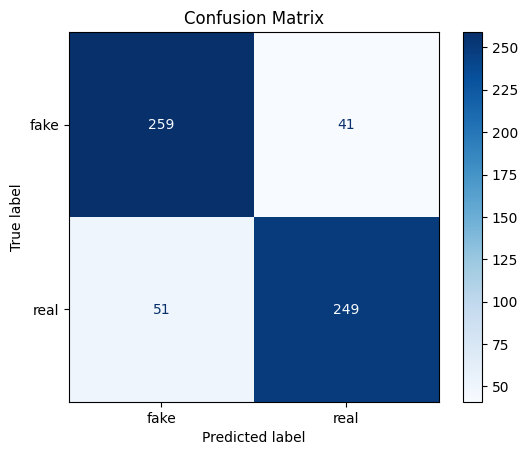

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Make predictions on the test set
y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_pred_probs = model.predict(test_ds)

# Assuming a binary classification task, threshold the predictions at 0.5
y_pred_classes = (y_pred_probs > 0.5).astype(int).flatten()

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [9]:
from keras.models import load_model
from keras.layers.experimental.preprocessing import Rescaling

# Load the saved model
model_path = '/content/drive/My Drive/checkpoints/Xception2/7/model_epoch_14_val_accuracy_0.9115.h5'
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 flatten_2 (Flatten)         (None, 100352)            0         
                                                                 
 dense_4 (Dense)             (None, 256)               25690368  
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 257       
                                                                 
Total params: 46552105 (177.58 MB)
Trainable params: 25690625 (98.00 MB)
Non-trainable params: 20861480 (79.58 MB)
_________________________________________________________________


In [ ]:
import os
import numpy as np

# Define a function to print each filename on a new line
def print_filenames(title, filenames):
    print(title + ":")
    for filename in filenames:
        print(filename)

# Assuming you've defined `test_dir` and `model` correctly
# Collect image paths
image_paths = [os.path.join(dp, f) for dp, dn, filenames in os.walk(test_dir) for f in filenames if os.path.splitext(f)[1].lower() in ['.jpg', '.jpeg', '.png']]
image_paths.sort()  # Sort to ensure the order matches the dataset

# Predictions and actual labels
predictions = model.predict(test_ds, verbose=0)  # Add verbose=0 to suppress output
predicted_classes = predictions.round().astype(int).flatten()
actual_labels = [label for _, label in test_ds.unbatch().as_numpy_iterator()]

# Lists for FP and FN images
false_positives = []
false_negatives = []

# Compare predictions with actual labels and classify mispredictions
for i, (predicted, actual) in enumerate(zip(predicted_classes, actual_labels)):
    if predicted != actual:
        if predicted < 0.5:  # False positive (predicted Fake, actual Real)
            false_positives.append(image_paths[i])
        else:  # False negative (predicted Real, actual Fake)
            false_negatives.append(image_paths[i])



False postive => Predicted as real but actually fake
False negative => Predicted as fake and actually real

In [ ]:
# Using the defined function to print filenames
print("Number of False Negatives" , len(false_negatives))
print_filenames("False Negatives", false_negatives[0:10])


Number of False Negatives 41
False Negatives:
/content/drive/My Drive/Sample/test/fake/photo_1113.jpg
/content/drive/My Drive/Sample/test/fake/photo_1323.jpg
/content/drive/My Drive/Sample/test/fake/photo_1564.jpg
/content/drive/My Drive/Sample/test/fake/photo_1997.jpg
/content/drive/My Drive/Sample/test/fake/photo_2010.jpg
/content/drive/My Drive/Sample/test/fake/photo_2011.jpg
/content/drive/My Drive/Sample/test/fake/photo_2017.jpg
/content/drive/My Drive/Sample/test/fake/photo_2018.jpg
/content/drive/My Drive/Sample/test/fake/photo_2020.jpg
/content/drive/My Drive/Sample/test/fake/photo_2023.jpg


In [ ]:
print("Number of False Positives" , len(false_positives))
print_filenames("False Positives", false_positives[0:10])


Number of False Positives 51
False Positives:
/content/drive/My Drive/Sample/test/real/61128.png
/content/drive/My Drive/Sample/test/real/61210.png
/content/drive/My Drive/Sample/test/real/61211.png
/content/drive/My Drive/Sample/test/real/61231.png
/content/drive/My Drive/Sample/test/real/61247.png
/content/drive/My Drive/Sample/test/real/61251.png
/content/drive/My Drive/Sample/test/real/61275.png
/content/drive/My Drive/Sample/test/real/61374.png
/content/drive/My Drive/Sample/test/real/61393.png
/content/drive/My Drive/Sample/test/real/61411.png


# Lime verification on best Model

In [ ]:
# Load your model
model = load_model('/content/drive/My Drive/checkpoints/Xception2/7/model_epoch_14_val_accuracy_0.9115.h5')

In [ ]:
def custom_preprocess_input(images):
    return images / 255.0  # Scale pixel values to [0, 1]

def predict_fn(images):
    processed_images = custom_preprocess_input(images)
    # Add verbose=0 to suppress progress messages
    return model.predict(processed_images, verbose=0)

In [ ]:
#false_negatives
process_image_list(false_negatives, explainer, predict_fn, model)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
#false_psitives
process_image_list(false_positives, explainer, predict_fn, model)

Output hidden; open in https://colab.research.google.com to view.

# Retraining 1 after Increasing training set; Test accuracy: 0.8767

In [ ]:
from keras.models import load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam

# Load the existing model from your checkpoint
model_path = '/content/drive/My Drive/checkpoints/Xception2/7/model_epoch_14_val_accuracy_0.9115.h5'
model = load_model(model_path)

# Adjust learning rate if necessary, often lower than initial training
optimizer = Adam(learning_rate=1e-4)  # Reduced learning rate for fine-tuning

# Re-compile the model with the new optimizer
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Set up training parameters
num_epochs = 20

checkpoint_path = '/content/drive/My Drive/checkpoints/Xception2/16/model_epoch_{epoch:02d}_val_accuracy_{val_accuracy:.4f}.h5'
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, save_best_only=False, monitor='val_accuracy', mode='max', verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Continue training the model
history = model.fit(
    train_generator,
    epochs=num_epochs,
    validation_data=Validation_generator,
    callbacks=[model_checkpoint, early_stopping]
)

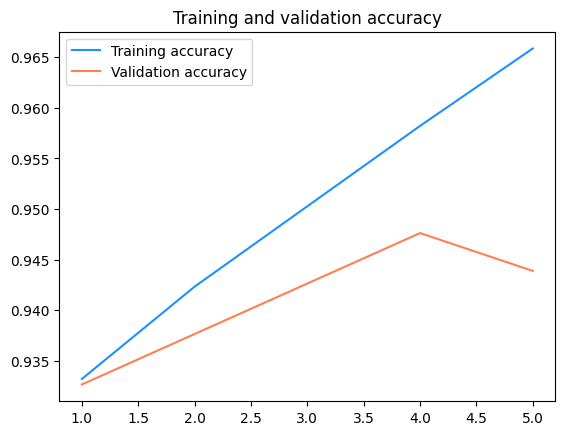

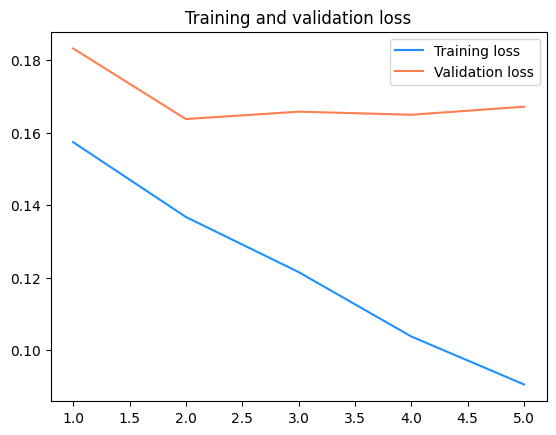

In [ ]:
# Plot the training and validation accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'dodgerblue', label='Training accuracy')
plt.plot(epochs, val_acc, 'coral', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'dodgerblue', label='Training loss')
plt.plot(epochs, val_loss, 'coral', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
from keras.models import load_model
from keras.layers.experimental.preprocessing import Rescaling

# Load the saved model
model_path = '/content/drive/My Drive/checkpoints/Xception2/8/model_epoch_04_val_accuracy_0.9476.h5'
model = load_model(model_path)

# Set the path to the test folder
test_dir = '/content/drive/My Drive/Sample/test'

# Define the batch size and image size
batch_size = 32
img_height = 224
img_width = 224

# Load the test data
test_ds = keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False)  # No need to shuffle the test data

class_names = test_ds.class_names
print("Class names:", class_names)

# Define the preprocessing layers
rescale_layer = Rescaling(1./255)

# Apply the rescaling layer to the test dataset
test_ds = test_ds.map(lambda x, y: (rescale_layer(x), y))

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_ds)
print(f'Test loss: {test_loss:.4f}, Test accuracy: {test_accuracy:.4f}')

Found 600 files belonging to 2 classes.
Class names: ['fake', 'real']
19/19 [==============================] - 37s 2s/step - loss: 0.3392 - accuracy: 0.8767
Test loss: 0.3392, Test accuracy: 0.8767


19/19 [==============================] - 3s 125ms/step


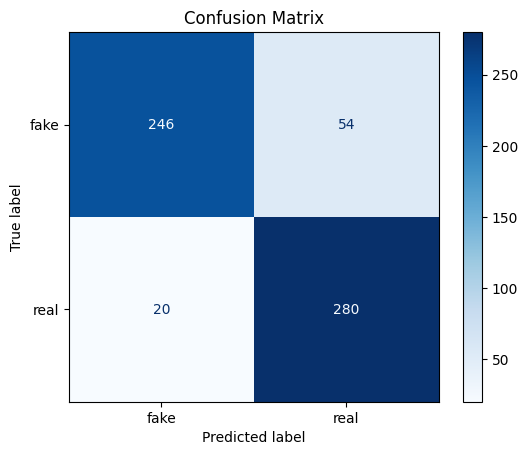

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Make predictions on the test set
y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_pred_probs = model.predict(test_ds)

# Assuming a binary classification task, threshold the predictions at 0.5
y_pred_classes = (y_pred_probs > 0.5).astype(int).flatten()

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Retraining 2 after increasing training set ; Test loss: 0.3290, Test accuracy: 0.8833

In [ ]:
from keras.models import load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam

# Load the existing model from your checkpoint
model_path = '/content/drive/My Drive/checkpoints/Xception2/7/model_epoch_14_val_accuracy_0.9115.h5'
model = load_model(model_path)

# Adjust learning rate if necessary, often lower than initial training
optimizer = Adam(learning_rate=1e-4)  # Reduced learning rate for fine-tuning

# Re-compile the model with the new optimizer
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Set up training parameters
num_epochs = 20

checkpoint_path = '/content/drive/My Drive/checkpoints/Xception2/9/model_epoch_{epoch:02d}_val_accuracy_{val_accuracy:.4f}.h5'
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, save_best_only=False, monitor='val_accuracy', mode='max', verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1)

# Continue training the model
history = model.fit(
    train_generator,  # Make sure to use your new or existing training generator
    epochs=num_epochs,
    validation_data=Validation_generator,  # And your validation generator
    callbacks=[model_checkpoint, early_stopping, reduce_lr]
)


Epoch 1/20
107/107 [==============================] - ETA: 0s - loss: 0.1578 - accuracy: 0.9329
Epoch 1: saving model to /content/drive/My Drive/checkpoints/Xception2/9/model_epoch_01_val_accuracy_0.9364.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


107/107 [==============================] - 47s 409ms/step - loss: 0.1578 - accuracy: 0.9329 - val_loss: 0.1732 - val_accuracy: 0.9364 - lr: 1.0000e-04
Epoch 2/20
107/107 [==============================] - ETA: 0s - loss: 0.1375 - accuracy: 0.9420
Epoch 2: saving model to /content/drive/My Drive/checkpoints/Xception2/9/model_epoch_02_val_accuracy_0.9277.h5
107/107 [==============================] - 44s 414ms/step - loss: 0.1375 - accuracy: 0.9420 - val_loss: 0.1872 - val_accuracy: 0.9277 - lr: 1.0000e-04
Epoch 3/20
107/107 [==============================] - ETA: 0s - loss: 0.1188 - accuracy: 0.9515
Epoch 3: saving model to /content/drive/My Drive/checkpoints/Xception2/9/model_epoch_03_val_accuracy_0.9239.h5

Epoch 3: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
107/107 [==============================] - 44s 413ms/step - loss: 0.1188 - accuracy: 0.9515 - val_loss: 0.1847 - val_accuracy: 0.9239 - lr: 1.0000e-04
Epoch 4/20
107/107 [==============================] - E

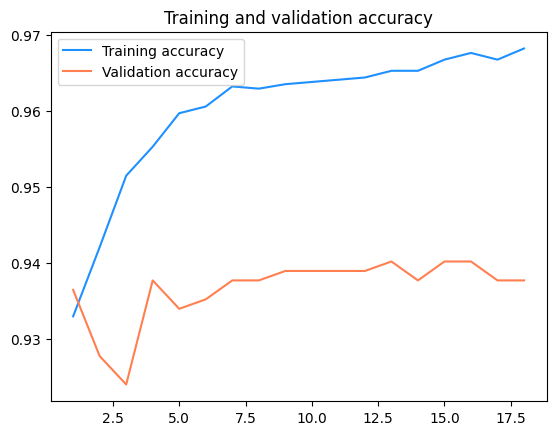

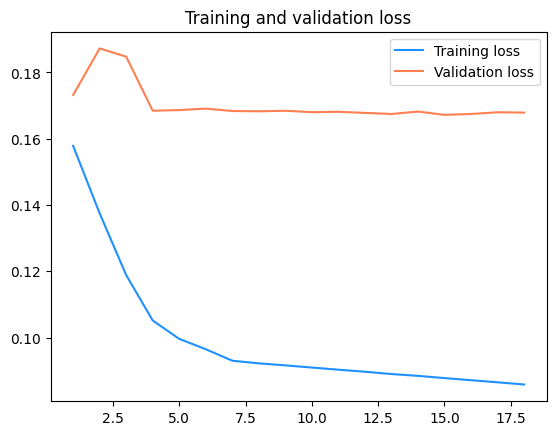

In [ ]:
# Plot the training and validation accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'dodgerblue', label='Training accuracy')
plt.plot(epochs, val_acc, 'coral', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'dodgerblue', label='Training loss')
plt.plot(epochs, val_loss, 'coral', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
from keras.models import load_model
from keras.layers.experimental.preprocessing import Rescaling

# Load the saved model
model_path = '/content/drive/My Drive/checkpoints/Xception2/9/model_epoch_01_val_accuracy_0.9364.h5'
model = load_model(model_path)

# Set the path to the test folder
test_dir = '/content/drive/My Drive/Sample/test'

# Define the batch size and image size
batch_size = 32
img_height = 224
img_width = 224

# Load the test data
test_ds = keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False)  # No need to shuffle the test data

class_names = test_ds.class_names
print("Class names:", class_names)

# Define the preprocessing layers
rescale_layer = Rescaling(1./255)

# Apply the rescaling layer to the test dataset
test_ds = test_ds.map(lambda x, y: (rescale_layer(x), y))

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_ds)
print(f'Test loss: {test_loss:.4f}, Test accuracy: {test_accuracy:.4f}')

Found 600 files belonging to 2 classes.
Class names: ['fake', 'real']
19/19 [==============================] - 3s 124ms/step - loss: 0.3402 - accuracy: 0.8650
Test loss: 0.3402, Test accuracy: 0.8650


19/19 [==============================] - 3s 122ms/step


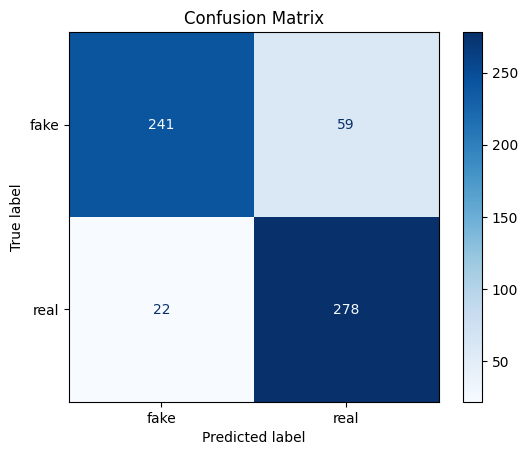

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Make predictions on the test set
y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_pred_probs = model.predict(test_ds)

# Assuming a binary classification task, threshold the predictions at 0.5
y_pred_classes = (y_pred_probs > 0.5).astype(int).flatten()

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

Found 600 files belonging to 2 classes.
Class names: ['fake', 'real']
19/19 [==============================] - 4s 157ms/step - loss: 0.3290 - accuracy: 0.8833
Test loss: 0.3290, Test accuracy: 0.8833
19/19 [==============================] - 3s 115ms/step


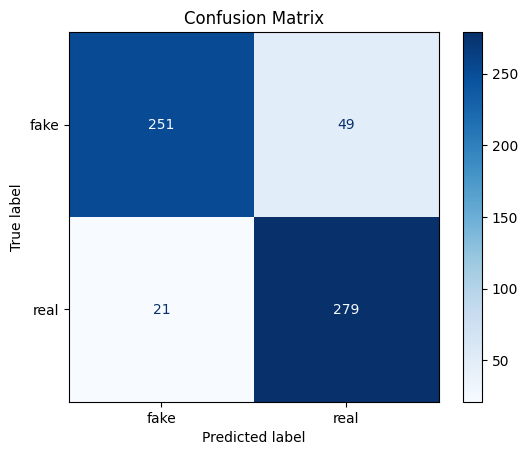

In [ ]:
#highest val_accuracy

from keras.models import load_model
from keras.layers.experimental.preprocessing import Rescaling

# Load the saved model
model_path = '/content/drive/My Drive/checkpoints/Xception2/9/model_epoch_13_val_accuracy_0.9401.h5'
model = load_model(model_path)

# Set the path to the test folder
test_dir = '/content/drive/My Drive/Sample/test'

# Define the batch size and image size
batch_size = 32
img_height = 224
img_width = 224

# Load the test data
test_ds = keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False)  # No need to shuffle the test data

class_names = test_ds.class_names
print("Class names:", class_names)

# Define the preprocessing layers
rescale_layer = Rescaling(1./255)

# Apply the rescaling layer to the test dataset
test_ds = test_ds.map(lambda x, y: (rescale_layer(x), y))

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_ds)
print(f'Test loss: {test_loss:.4f}, Test accuracy: {test_accuracy:.4f}')

import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Make predictions on the test set
y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_pred_probs = model.predict(test_ds)

# Assuming a binary classification task, threshold the predictions at 0.5
y_pred_classes = (y_pred_probs > 0.5).astype(int).flatten()

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


# Retraining 3, best model + optimization and the increased dataset, 0.8850

In [ ]:
# Load the Xception model pre-trained on ImageNet, excluding its top (fully connected) layers
base_model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the base model to prevent them from being updated during training
for layer in base_model.layers:
    layer.trainable = False


model = Sequential([
    base_model,
    Flatten(),  # Flatten the output of the base model to a 1D vector
    Dense(256, activation='relu'),  # Add a fully connected layer with 256 units and ReLU activation
    Dropout(0.2),  # Add dropout for regularization (reduce overfitting)
    Dense(1, activation='sigmoid')  # Add the output layer with sigmoid activation for binary classification
])

# Model compilation with Adam activation and binary_crossentropy loss function, good for binary classifications
# Metrics also included

model.compile(optimizer=Adam(learning_rate= 1e-3),
               loss='binary_crossentropy',
               metrics=['accuracy'])

# Model training
num_epochs = 20
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint_path = '/content/drive/My Drive/checkpoints/Xception2/10/model_epoch_{epoch:02d}_val_accuracy_{val_accuracy:.4f}.h5'
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, save_best_only=False, monitor='val_accuracy', mode='max', verbose=1, patience=2)


history = model.fit(
    train_generator,
    epochs=num_epochs,
    validation_data=Validation_generator,
    callbacks=[model_checkpoint, early_stopping]
)

Epoch 1/20
107/107 [==============================] - ETA: 0s - loss: 1.2842 - accuracy: 0.7817
Epoch 1: saving model to /content/drive/My Drive/checkpoints/Xception2/10/model_epoch_01_val_accuracy_0.8703.h5
107/107 [==============================] - 48s 415ms/step - loss: 1.2842 - accuracy: 0.7817 - val_loss: 0.3139 - val_accuracy: 0.8703
Epoch 2/20
107/107 [==============================] - ETA: 0s - loss: 0.2713 - accuracy: 0.8844
Epoch 2: saving model to /content/drive/My Drive/checkpoints/Xception2/10/model_epoch_02_val_accuracy_0.9190.h5
107/107 [==============================] - 44s 409ms/step - loss: 0.2713 - accuracy: 0.8844 - val_loss: 0.1984 - val_accuracy: 0.9190
Epoch 3/20
107/107 [==============================] - ETA: 0s - loss: 0.2019 - accuracy: 0.9150
Epoch 3: saving model to /content/drive/My Drive/checkpoints/Xception2/10/model_epoch_03_val_accuracy_0.8865.h5
107/107 [==============================] - 45s 423ms/step - loss: 0.2019 - accuracy: 0.9150 - val_loss: 0.28

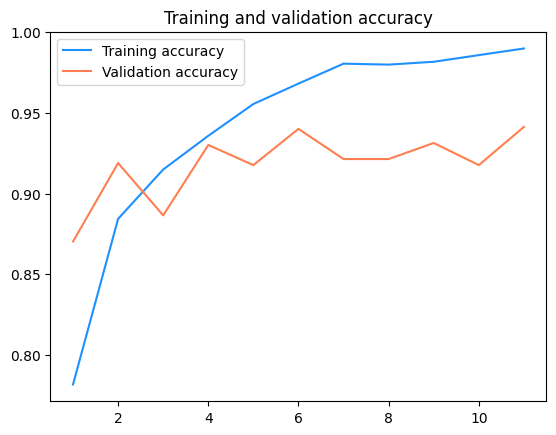

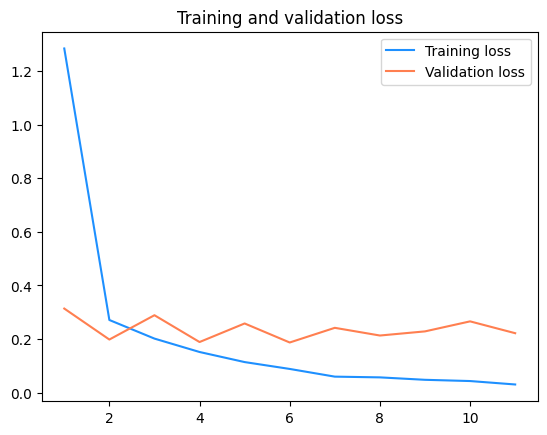

In [ ]:
# Plot the training and validation accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'dodgerblue', label='Training accuracy')
plt.plot(epochs, val_acc, 'coral', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'dodgerblue', label='Training loss')
plt.plot(epochs, val_loss, 'coral', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Found 600 files belonging to 2 classes.
Class names: ['fake', 'real']
19/19 [==============================] - 3s 125ms/step - loss: 0.5667 - accuracy: 0.8850
Test loss: 0.5667, Test accuracy: 0.8850
19/19 [==============================] - 3s 123ms/step


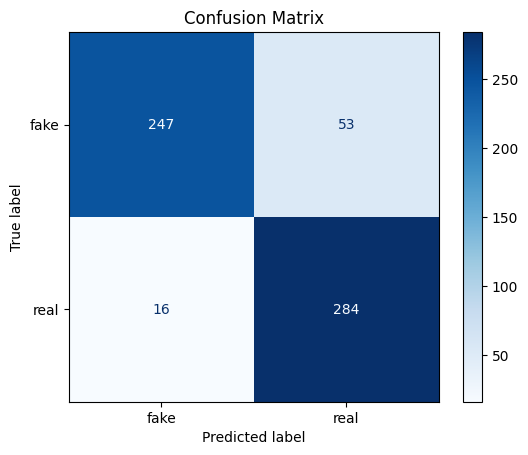

In [ ]:
from keras.models import load_model
from keras.layers.experimental.preprocessing import Rescaling

#highest val_accuracy

from keras.models import load_model
from keras.layers.experimental.preprocessing import Rescaling

# Load the saved model
model_path = '/content/drive/My Drive/checkpoints/Xception2/10/model_epoch_11_val_accuracy_0.9414.h5'
model = load_model(model_path)

# Set the path to the test folder
test_dir = '/content/drive/My Drive/Sample/test'

# Define the batch size and image size
batch_size = 32
img_height = 224
img_width = 224

# Load the test data
test_ds = keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False)  # No need to shuffle the test data

class_names = test_ds.class_names
print("Class names:", class_names)

# Define the preprocessing layers
rescale_layer = Rescaling(1./255)

# Apply the rescaling layer to the test dataset
test_ds = test_ds.map(lambda x, y: (rescale_layer(x), y))

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_ds)
print(f'Test loss: {test_loss:.4f}, Test accuracy: {test_accuracy:.4f}')

import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Make predictions on the test set
y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_pred_probs = model.predict(test_ds)

# Assuming a binary classification task, threshold the predictions at 0.5
y_pred_classes = (y_pred_probs > 0.5).astype(int).flatten()

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


Found 600 files belonging to 2 classes.
19/19 [==============================] - 129s 7s/step


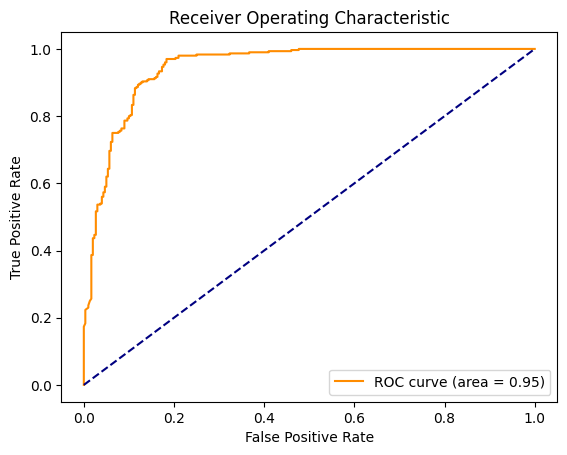

In [10]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve, accuracy_score, auc

# Load the saved model
model_path = '/content/drive/My Drive/checkpoints/Xception2/10/model_epoch_11_val_accuracy_0.9414.h5'
model = load_model(model_path)

# Set the path to the test folder
test_dir = '/content/drive/My Drive/Sample/test'

# Define the batch size and image size
batch_size = 32
img_height = 224
img_width = 224

# Load the test data
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False)  # No need to shuffle the test data

# Apply rescaling
test_ds = test_ds.map(lambda x, y: (x / 255.0, y))

# Collect batches into data and labels for metrics computation
y_true = np.concatenate([y.numpy() for _, y in test_ds])
y_pred_prob = model.predict(test_ds)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()  # Class 'real' as 1, 'fake' as 0

# Reverse predictions for 'fake' as positive
y_pred_rev = 1 - y_pred
y_true_rev = 1 - y_true

# Compute metrics with 'fake' as positive
precision = precision_score(y_true_rev, y_pred_rev)
recall = recall_score(y_true_rev, y_pred_rev)
f1 = f1_score(y_true_rev, y_pred_rev)
accuracy = accuracy_score(y_true_rev, y_pred_rev)
roc_auc = 1 - roc_auc_score(y_true_rev, y_pred_prob)  # Calculate AUC with probabilities

# Calculate ROC curve
fpr, tpr, _ = roc_curve(y_true_rev, y_pred_prob)
roc_auc_val = 1 - auc(fpr, tpr)

# Plot ROC Curve
plt.figure()
plt.plot(tpr, fpr, color='darkorange', label=f'ROC curve (area = {roc_auc_val:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [8]:
from keras.models import load_model
from keras.layers.experimental.preprocessing import Rescaling

# Load the saved model
model_path = '/content/drive/My Drive/checkpoints/Xception2/10/model_epoch_11_val_accuracy_0.9414.h5'
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 flatten_2 (Flatten)         (None, 100352)            0         
                                                                 
 dense_4 (Dense)             (None, 256)               25690368  
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 257       
                                                                 
Total params: 46552105 (177.58 MB)
Trainable params: 25690625 (98.00 MB)
Non-trainable params: 20861480 (79.58 MB)
_________________________________________________________________


Found 600 files belonging to 2 classes.
Class names: ['fake', 'real']
19/19 [==============================] - 152s 7s/step - loss: 0.4062 - accuracy: 0.8417
Test loss: 0.4062, Test accuracy: 0.8417
19/19 [==============================] - 140s 7s/step


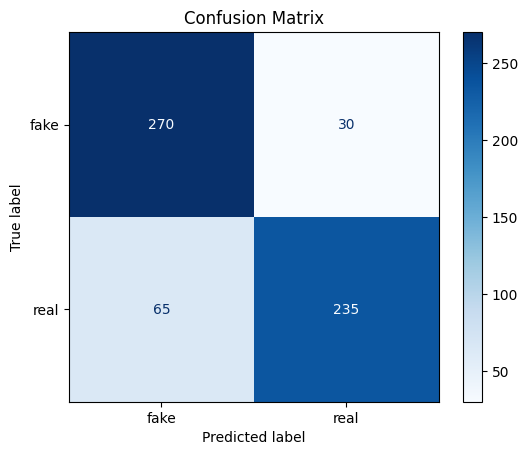

In [7]:
from keras.models import load_model
from keras.layers.experimental.preprocessing import Rescaling

#highest val_accuracy

from keras.models import load_model
from keras.layers.experimental.preprocessing import Rescaling

# Load the saved model
model_path = '/content/drive/My Drive/checkpoints/Xception2/10/model_epoch_03_val_accuracy_0.8865.h5'
model = load_model(model_path)

# Set the path to the test folder
test_dir = '/content/drive/My Drive/Sample/test'

# Define the batch size and image size
batch_size = 32
img_height = 224
img_width = 224

# Load the test data
test_ds = keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False)  # No need to shuffle the test data

class_names = test_ds.class_names
print("Class names:", class_names)

# Define the preprocessing layers
rescale_layer = Rescaling(1./255)

# Apply the rescaling layer to the test dataset
test_ds = test_ds.map(lambda x, y: (rescale_layer(x), y))

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_ds)
print(f'Test loss: {test_loss:.4f}, Test accuracy: {test_accuracy:.4f}')

import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Make predictions on the test set
y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_pred_probs = model.predict(test_ds)

# Assuming a binary classification task, threshold the predictions at 0.5
y_pred_classes = (y_pred_probs > 0.5).astype(int).flatten()

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


# VGG19 retraining; Test accuracy: 0.8683


In [ ]:
# Load the Xception model pre-trained on ImageNet, excluding its top (fully connected) layers
base_model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the base model to prevent them from being updated during training
for layer in base_model.layers:
    layer.trainable = False

model = Sequential([
    base_model,
    Flatten(),  # Flatten the output of the base model to a 1D vector
    Dense(256, activation='relu'),  # Add a fully connected layer with 256 units and ReLU activation
    Dropout(0.4),  # Add dropout for regularization (reduce overfitting)
    Dense(1, activation='sigmoid')  # Add the output layer with sigmoid activation for binary classification
])

# Model compilation with Adam optimizer and binary_crossentropy loss function
model.compile(optimizer=Adam(learning_rate=1e-3),
               loss='binary_crossentropy',
               metrics=['accuracy'])

# Model training parameters
num_epochs = 20
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint_path = '/content/drive/My Drive/checkpoints/Xception2/11/model_epoch_{epoch:02d}_val_accuracy_{val_accuracy:.4f}.h5'
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)

# Train the model
history = model.fit(
    train_generator,
    epochs=num_epochs,
    validation_data=Validation_generator,
    callbacks=[early_stopping, model_checkpoint]
)

# Note: Ensure `train_generator` and `validation_generator` are properly configured.


Epoch 1/20
107/107 [==============================] - ETA: 0s - loss: 1.5152 - accuracy: 0.7835
Epoch 1: val_accuracy improved from -inf to 0.88653, saving model to /content/drive/My Drive/checkpoints/Xception2/11/model_epoch_01_val_accuracy_0.8865.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


107/107 [==============================] - 47s 415ms/step - loss: 1.5152 - accuracy: 0.7835 - val_loss: 0.2837 - val_accuracy: 0.8865
Epoch 2/20
107/107 [==============================] - ETA: 0s - loss: 0.3506 - accuracy: 0.8629
Epoch 2: val_accuracy improved from 0.88653 to 0.89027, saving model to /content/drive/My Drive/checkpoints/Xception2/11/model_epoch_02_val_accuracy_0.8903.h5
107/107 [==============================] - 45s 422ms/step - loss: 0.3506 - accuracy: 0.8629 - val_loss: 0.2606 - val_accuracy: 0.8903
Epoch 3/20
107/107 [==============================] - ETA: 0s - loss: 0.2450 - accuracy: 0.8967
Epoch 3: val_accuracy improved from 0.89027 to 0.89651, saving model to /content/drive/My Drive/checkpoints/Xception2/11/model_epoch_03_val_accuracy_0.8965.h5
107/107 [==============================] - 45s 423ms/step - loss: 0.2450 - accuracy: 0.8967 - val_loss: 0.2465 - val_accuracy: 0.8965
Epoch 4/20
107/107 [==============================] - ETA: 0s - loss: 0.1931 - accuracy:

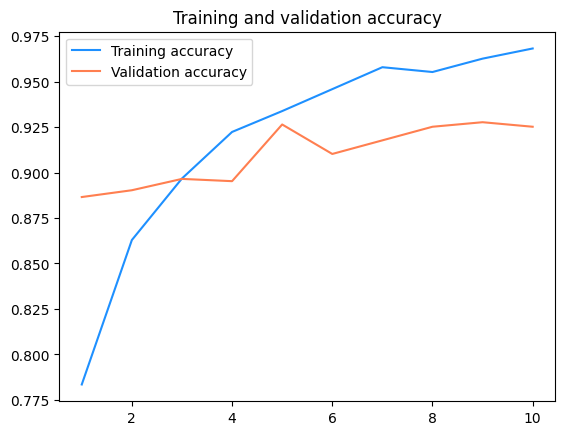

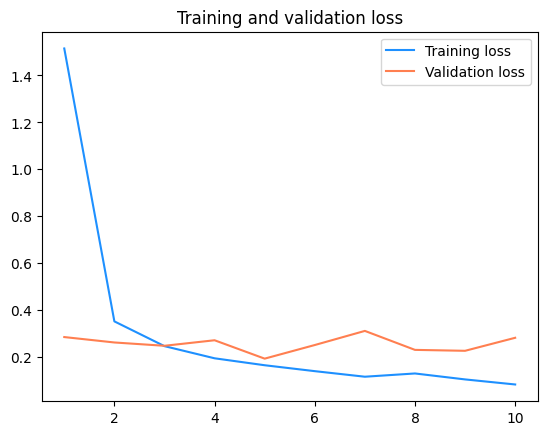

In [ ]:
# Plot the training and validation accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'dodgerblue', label='Training accuracy')
plt.plot(epochs, val_acc, 'coral', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'dodgerblue', label='Training loss')
plt.plot(epochs, val_loss, 'coral', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
from keras.models import load_model
from keras.layers.experimental.preprocessing import Rescaling

# Load the saved model
model_path = '/content/drive/My Drive/checkpoints/Xception2/11/model_epoch_09_val_accuracy_0.9277.h5'
model = load_model(model_path)

# Set the path to the test folder
test_dir = '/content/drive/My Drive/Sample/test'

# Define the batch size and image size
batch_size = 32
img_height = 224
img_width = 224

# Load the test data
test_ds = keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False)  # No need to shuffle the test data

class_names = test_ds.class_names
print("Class names:", class_names)

# Define the preprocessing layers
rescale_layer = Rescaling(1./255)

# Apply the rescaling layer to the test dataset
test_ds = test_ds.map(lambda x, y: (rescale_layer(x), y))

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_ds)
print(f'Test loss: {test_loss:.4f}, Test accuracy: {test_accuracy:.4f}')


Found 600 files belonging to 2 classes.
Class names: ['fake', 'real']
19/19 [==============================] - 4s 178ms/step - loss: 0.5065 - accuracy: 0.8750
Test loss: 0.5065, Test accuracy: 0.8750


19/19 [==============================] - 3s 135ms/step


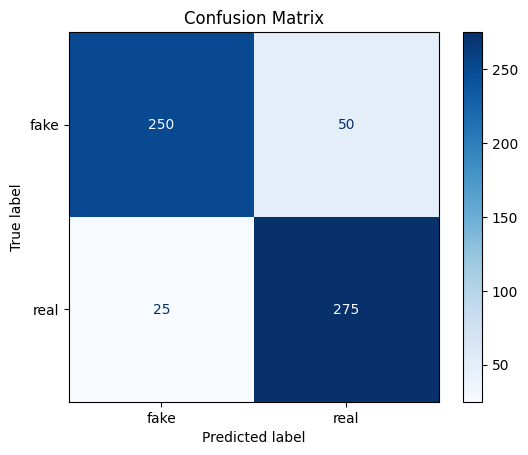

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Make predictions on the test set
y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_pred_probs = model.predict(test_ds)

# Assuming a binary classification task, threshold the predictions at 0.5
y_pred_classes = (y_pred_probs > 0.5).astype(int).flatten()

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()
